---

###### Data Science for Smart Environments - January 2024 - Final delivery.

---

# Objective 1: Analyze the contribution of sources of Nitrogen Oxides (NOx) to the air pollution in Poland in 2019

**Hudson Passos** (1311182), **Qin Xu** (1274376).

---

**Importing libraries:**

For **Google Colab**: install (below) the libraries "rasterio" and "pykrige"

In [1]:
#pip install rasterio

In [2]:
#pip install pykrige

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
#%matplotlib inline
from shapely.geometry import Point
from shapely import geometry
from io import BytesIO
import os
from os.path import exists
import requests
import zipfile
from osgeo import gdal
from osgeo import osr
from PIL import Image
import rasterio
import rasterio.mask
from rasterio.plot import show
import fiona
from tqdm import tqdm
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import warnings
warnings.filterwarnings('ignore')

**Importing figures:**

In [9]:
url1 = 'https://github.com/hudsonpassos85/DSSE/blob/main/images/figure01.jpg?raw=true'
response = requests.get(url1)
figure1 = Image.open(BytesIO(response.content))
url2 = 'https://github.com/hudsonpassos85/DSSE/blob/main/images/figure02.jpg?raw=true'
response = requests.get(url2)
figure2 = Image.open(BytesIO(response.content))

image_folder = "image"
parent_dir = os.getcwd()
path_image = os.path.join(parent_dir, image_folder) 

if not os.path.exists(path_image):
    os.mkdir(path_image)

figure1.save(os.path.join(path_image, "figure1.png"))
figure2.save(os.path.join(path_image, "figure2.png"))

---

### Summary


1) Acquire data of the same time  

2) Assemble a dataset with relevant features, including air quality data and potential contributing factors such as traffic, industrial, power plant. 

3) Handle missing data, outliers, and standardize/normalize numerical variables. Ensure that the dataset is properly formatted for the training model. 

4) Combine the data from different sources to make an integrated dataframe.

5) Generate graphs and choropleth maps for data analysis.

6) Divide the dataset into training and testing sets. 

7) Use a XGBoost model, train the model using training dataset. 

8) Assess the performance of the model using the test dataset. 

9) Extract feature importance scores from the trained XGBoost model. 

10) Analyze the feature importance results to identify which variables have the most significant impact on air quality in Poland in 2019 in each province. 

 ![Figure](image\figure1.png)

**Datasets used on this study:**
1) **Provinces**: shapefile with province administrative boundaries that will be used as a base dataframe and will receive information from the other datasets.
2) **Traffic**: emissions (in tonnes) of pollutants (NOx) per provinces. 
3) **Industrial**: emissions (in kg) of pollutants (NOx) in facility level from diverse sectors (energy, waste management, metal production, etc.)
4) **Air Pollution**: NOx air pollutant concentration (in µg/m3) acquired by air quality monitoring stations in Poland.

As the figure below shows, NOx air pollutant was chosen because it was present all the data we used to carry on this study. **MORE TEXT HERE**

 ![Figure](image\figure2.png)

### Creating folders to storage datasets

In [7]:
# Directory 
directory = "original_datasets"
preprocessed_datasets = "preprocessed_datasets"

# Parent Directory path 
parent_dir = os.getcwd()

# Datasets path 
data_path = os.path.join(parent_dir, directory) 
pp_data_path = os.path.join(parent_dir, preprocessed_datasets)

# Path 
path = os.path.join(parent_dir, directory) 
path_pp = os.path.join(parent_dir, directory) 

# Create the directory 
if not os.path.exists(path):
    os.mkdir(path)
    print("Directory '% s' created" % directory)
else:
    print("Directory '% s' already exists" % directory)
    
if not os.path.exists(pp_data_path):
    os.mkdir(pp_data_path)
    print("Directory '% s' created" % preprocessed_datasets)
else:
    print("Directory '% s' already exists" % preprocessed_datasets)

Directory 'original_datasets' already exists
Directory 'preprocessed_datasets' already exists


### Download data

**Poland shapefile**:

In [8]:
if not exists(os.path.join(data_path,'polska.zip')):
    url = "https://www.gis-support.pl/downloads/2022/polska.zip?_ga=2.166715006.1552088728.1705918794-1217077323.1704915850&_gl=1*fwsmxx*_ga*MTIxNzA3NzMyMy4xNzA0OTE1ODUw*_ga_6DGXL861WD*MTcwNTkyNTY2NC4zLjAuMTcwNTkyNTY2NC42MC4wLjA."

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, 'polska.zip'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

In [9]:
if not exists(os.path.join(data_path, 'polska.shp')):
    with zipfile.ZipFile(os.path.join(data_path, 'polska.zip'), 'r') as zip_ref:
        zip_ref.extractall(data_path)

**Provinces of Poland shapefile**:

In [10]:
if not exists(os.path.join(data_path, 'wojewodztwa.zip')):
    url = "https://www.gis-support.pl/downloads/2022/wojewodztwa.zip?_ga=2.101554881.1552088728.1705918794-1217077323.1704915850&_gl=1*b5kvn0*_ga*MTIxNzA3NzMyMy4xNzA0OTE1ODUw*_ga_6DGXL861WD*MTcwNTkyNTY2NC4zLjAuMTcwNTkyNTY2NC42MC4wLjA."

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, 'wojewodztwa.zip'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

In [11]:
if not exists(os.path.join(data_path, 'wojewodztwa.shp')):
    with zipfile.ZipFile(os.path.join(data_path, 'wojewodztwa.zip'), 'r') as zip_ref:
        zip_ref.extractall(data_path)

**Industrial Emissions dataset**:

In [12]:
if not exists(os.path.join(data_path, 'F1_4_Detailed releases at facility level with E-PRTR Sector and Annex I Activity detail into Air.csv')):
    url = "https://sdi.eea.europa.eu/datashare/s/sDZMm9YpGB3TdQ9/download?path=%2FUser%20friendly%20.csv%20file&files=F1_4_Detailed%20releases%20at%20facility%20level%20with%20E-PRTR%20Sector%20and%20Annex%20I%20Activity%20detail%20into%20Air.csv"

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, 'F1_4_Detailed releases at facility level with E-PRTR Sector and Annex I Activity detail into Air.csv'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

**Traffic dataset (already preprocessed on my Github account)**:

In [13]:
if not exists(os.path.join(data_path, '2019_CH4.csv')):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/preprocessed%20data/2019_CH4.csv"

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, '2019_CH4.csv'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

if not exists(os.path.join(data_path, '2019_N2O.csv')):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/preprocessed%20data/2019_N2O.csv"

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, '2019_N2O.csv'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

if not exists(os.path.join(data_path, '2019_NMVOC.csv')):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/preprocessed%20data/2019_NMVOC.csv"

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, '2019_NMVOC.csv'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

if not exists(os.path.join(data_path, '2019_NOx.csv')):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/preprocessed%20data/2019_NOx.csv"

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, '2019_NOx.csv'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

In [14]:
if not exists(os.path.join(data_path, 'Metadane oraz kody stacji i stanowisk pomiarowych.xlsx')):
    url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/522"

    response = requests.get(url, stream=True)
    with open(os.path.join(parent_dir, directory, 'Metadane oraz kody stacji i stanowisk pomiarowych.xlsx'), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

In [15]:
if not exists(os.path.join(data_path, "Wyniki pomiarów z 2019 roku", 'Metadane oraz kody stacji i stanowisk pomiarowych.xlsx')):
    url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/322"

    response = requests.get(url, stream=True)
    with open(os.path.join(data_path, "Wyniki pomiarów z 2019 roku.zip"), "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
    if not os.path.exists(os.path.join(data_path, "Wyniki pomiarów z 2019 roku")):
        os.mkdir(os.path.join(data_path, "Wyniki pomiarów z 2019 roku"))
        print("Directory '% s' created" % directory)
    else:
        print("Directory '% s' already exists" % directory)                
                
    with zipfile.ZipFile(os.path.join(data_path, "Wyniki pomiarów z 2019 roku.zip"), 'r') as zip_ref:
        zip_ref.extractall(os.path.join(data_path, "Wyniki pomiarów z 2019 roku"))

Directory 'original_datasets' already exists


---

### Reading files
**1) Provinces of Poland (shapefile)**

In [16]:
provinces = gpd.read_file(os.path.join(data_path, "wojewodztwa.shp"))

In [17]:
print(provinces.crs)

EPSG:2180


**Reprojecting CRS from *EPSG:2180* to *EPSG:4326*:**

In [18]:
provinces  = provinces.to_crs({'init': 'epsg:4326'})

In [19]:
print(provinces.crs)

+init=epsg:4326 +type=crs


**Filtering relevant information and renaming the column names:**

In [20]:
provinces = provinces[["JPT_NAZWA_", "SHAPE_AREA", "geometry"]]
provinces.columns = ["NAME", "AREA", "geometry"]
provinces.head(2)

,NAME,AREA,geometry
0,zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417..."
1,lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153..."


---

### Reading files: 
**2) Traffic (csv)**

In [21]:
traffic_ch4 = pd.read_csv(os.path.join(data_path, "2019_CH4.csv"))
traffic_n2o = pd.read_csv(os.path.join(data_path, "2019_N2O.csv"))
traffic_nmvoc = pd.read_csv(os.path.join(data_path, "2019_NMVOC.csv"))
traffic_nox = pd.read_csv(os.path.join(data_path, "2019_NOx.csv"))

**The emissions of all data will be compared in terms of "tonnes":**

In [22]:
traffic_ch4["Total_kg"] = traffic_ch4["Total_tonnes"] * 1000
traffic_n2o["Total_kg"] = traffic_n2o["Total_tonnes"] * 1000
traffic_nmvoc["Total_kg"] = traffic_nmvoc["Total_tonnes"] * 1000
traffic_nox["Total_kg"] = traffic_nox["Total_tonnes"] * 1000

**The datasets contain province names written in different ways: using the Polish alphabet or Latin alphabet. Some datasets include also behind the names the word "voivodship", which means "province" in English. It is necessary to standardize the province's names to the written in exactly the same way in every dataset. Here we make a dictionary to convert the original names to the standardized ones:**

In [23]:
province_names_list = []

for i in range(len(traffic_ch4)):
    
    name = traffic_ch4["Voivodship"][i].split(" ")[0]
    province_names_list.append(name)    

In [24]:
# dictionaries:

dic_traffic_to_standard = dict(zip(province_names_list, 
                          traffic_ch4["Voivodship"].copy()))

dic_provinces_to_standard = dict(zip(province_names_list, 
                          provinces["NAME"].reindex(index = [4, 15, 5, 7, 12, 9, 13, 10, 14, 1, 3, 6, 11, 2, 8, 0]))).copy()

In [25]:
def standard_names_for_provinces(dictionary, df_to_be_changed, name_column):
    for i,j in dictionary.items():
        idx = df_to_be_changed[df_to_be_changed[name_column]==j].index
        df_to_be_changed.loc[idx, name_column]=i
    return df_to_be_changed

In [26]:
traffic_ch4 = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_ch4, name_column = "Voivodship")
traffic_n2o = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_n2o, name_column = "Voivodship")
traffic_nmvoc = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_nmvoc, name_column = "Voivodship")
traffic_nox = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_nox, name_column = "Voivodship")
provinces = standard_names_for_provinces(dictionary = dic_provinces_to_standard, df_to_be_changed = provinces, name_column = "NAME")

---

**Reading files:** \
\
**3) Industrial dataset (csv)**

In [27]:
industry = pd.read_csv(os.path.join(data_path, "F1_4_Detailed releases at facility level with E-PRTR Sector and Annex I Activity detail into Air.csv"))

Filtering the data for **"Poland"** in **"2019"**:

In [28]:
industry_pl2019 = industry[(industry["countryName"]=="Poland") & (industry["reportingYear"]==2019)].reset_index(drop=True)

**Converting it to a geopandas dataframe, with crs = EPSG:4326:**

In [29]:
industry_pl2019gpd = gpd.GeoDataFrame(
    industry_pl2019, geometry=gpd.points_from_xy(industry_pl2019.Longitude, industry_pl2019.Latitude), crs="EPSG:4326")

In [30]:
industry_pl2019gpd.head(2)

,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,facilityNameConfidentialityReason,Longitude,Latitude,addressConfidentialityReason,City,targetRelease,pollutant,emissions,reportingYear,releasesConfidentialityReason,geometry
0,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000004.FACILITY,Ciepłownia Miejska,NaN,20.448046,52.068836,NaN,Żyrardów,AIR,Sulphur oxides (SOX),163000.0,2019,NaN,POINT (20.44805 52.06884)
1,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000005.FACILITY,Zakład Z-2 Knurów,NaN,18.678440,50.215218,NaN,Knurów,AIR,Sulphur oxides (SOX),152000.0,2019,NaN,POINT (18.67844 50.21522)


**Plotting the provinces and industries (color: sector names):**

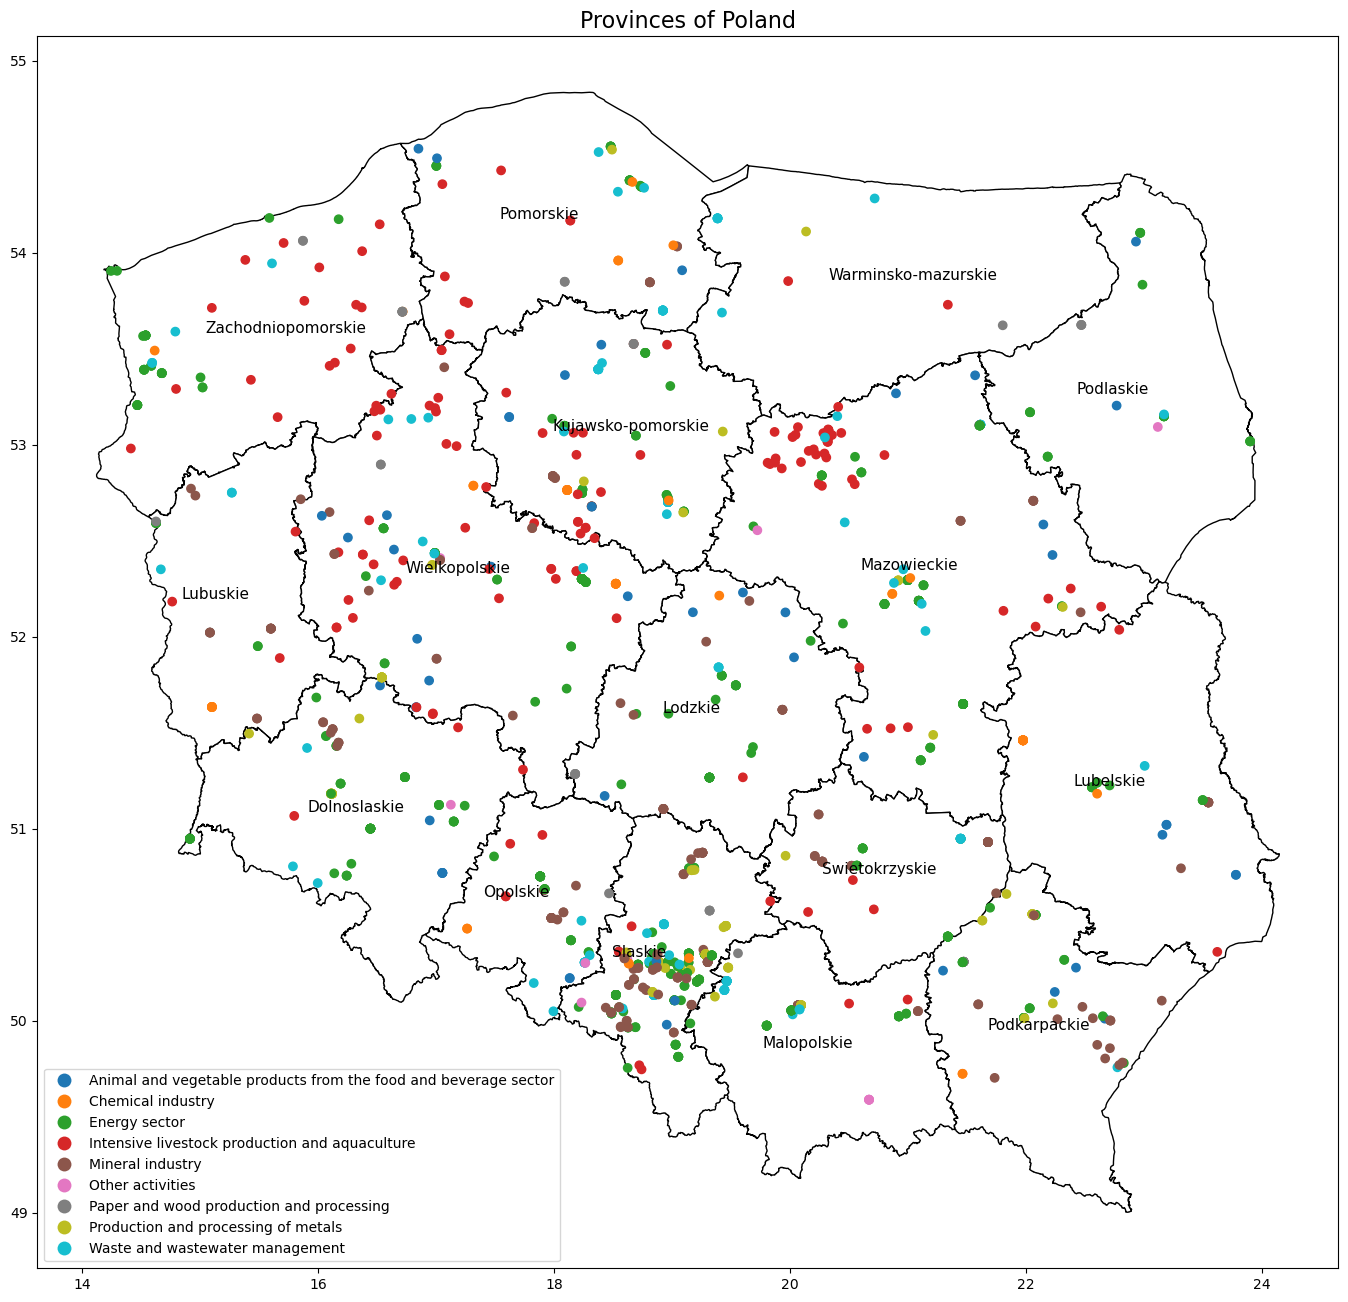

In [31]:
p = provinces.plot(color="white", edgecolor="black", figsize = (20,16))

# Some hassle to add annotation to the map (found solution via Google)
provinces["CENTER"] = provinces["geometry"].centroid
provinces_points = provinces.copy()
provinces_points.set_geometry(provinces["CENTER"], inplace = True)
texts = []

for x, y, label in zip(provinces_points.geometry.x, provinces_points.geometry.y, provinces_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
industry_pl2019gpd.plot(column='eprtrSectorName', ax=p, figsize = (20,16), legend=True)

p.set_title('Provinces of Poland', fontsize=16)
plt.show()

**Now we want relate each of those points (industries) to the province where they are within. \
First, we will reset the indexes to create a new column of indexes. Then it is easier to use this new column to connect both datasets:**

In [32]:
ind = industry_pl2019gpd.copy()
ind = ind.reset_index()

In [33]:
ind["PROVINCE"]=""

for i in tqdm(range(len(provinces))):
    df = gpd.overlay(ind, provinces[provinces["NAME"]==provinces["NAME"][i]], how='intersection')
    ind.loc[df["index"],"PROVINCE"]=provinces["NAME"][i]
  

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


**Now, it is better check if everything worked well. Let's plot all the points with color according to the province where they are associated to:**

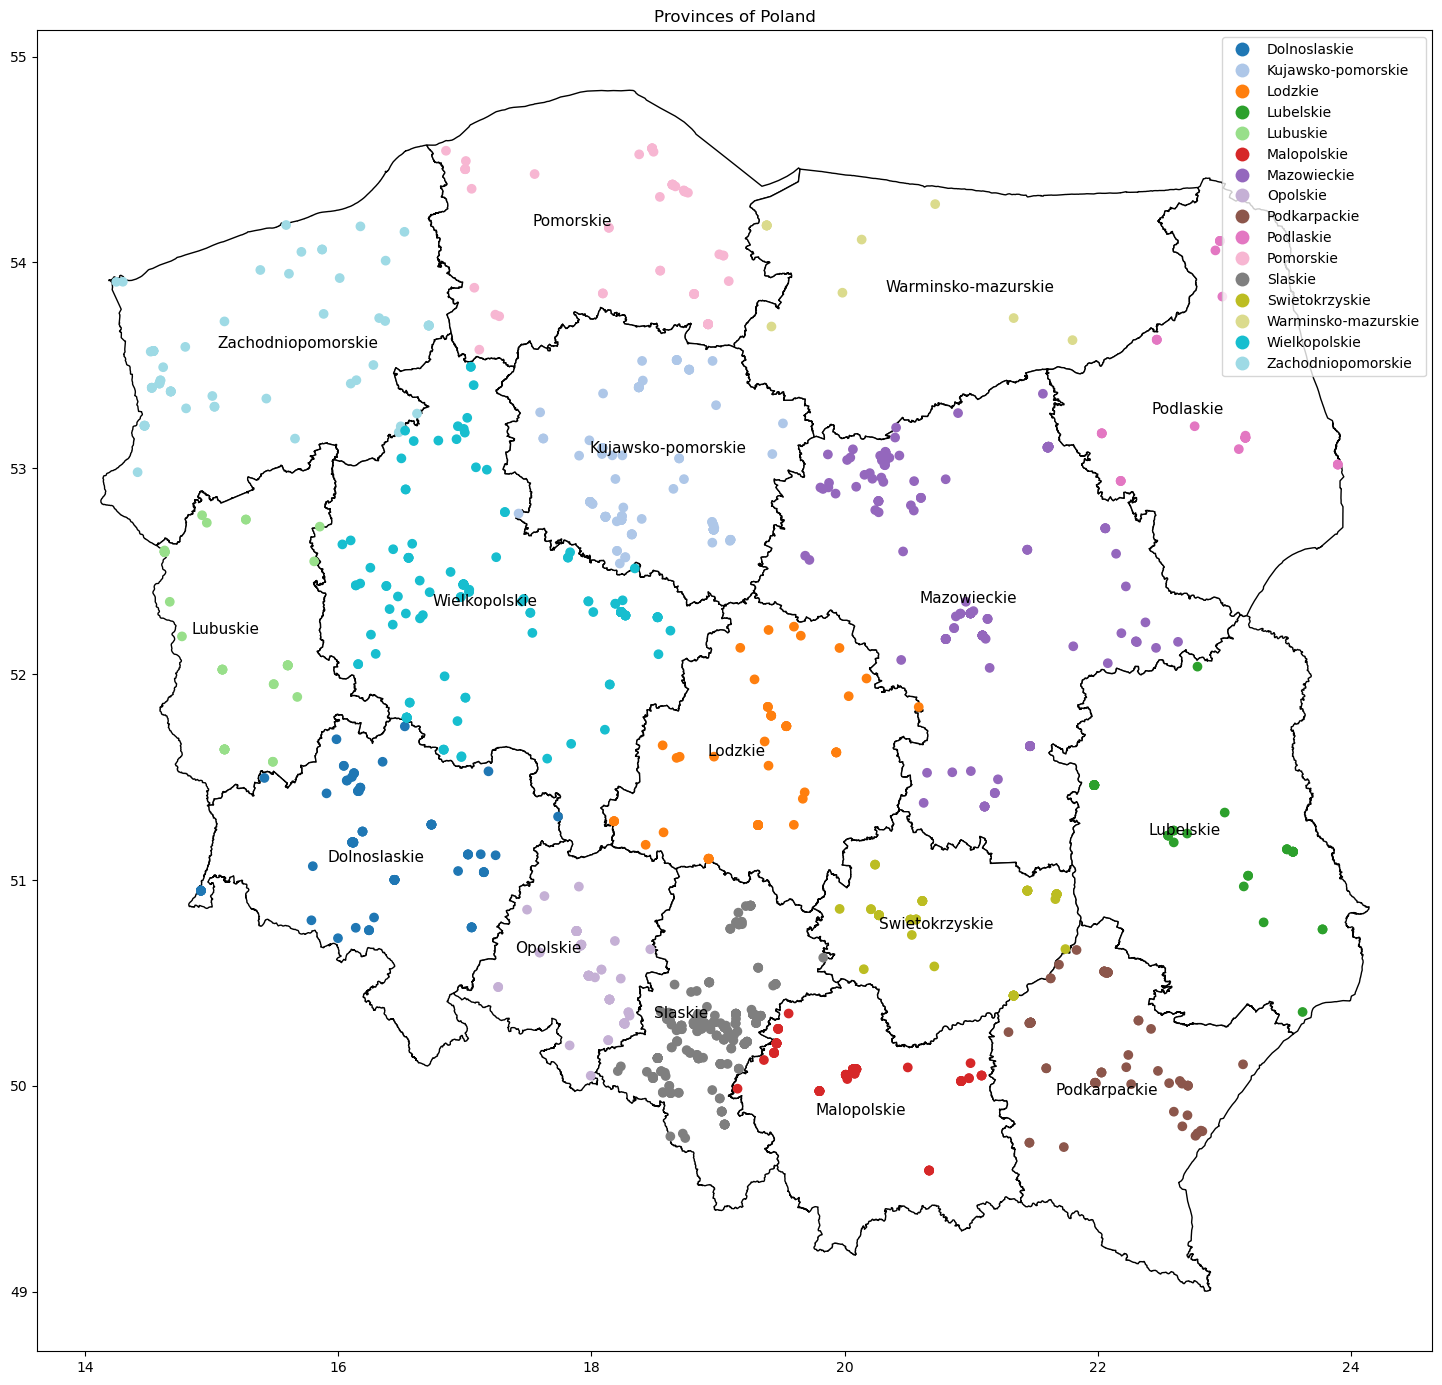

In [34]:
p = provinces.plot(color="white", edgecolor="black", figsize = (18,18))

# Some hassle to add annotation to the map (found solution via Google)
provinces["CENTER"] = provinces["geometry"].centroid
provinces_points = provinces.copy()
provinces_points.set_geometry(provinces["CENTER"], inplace = True)
texts = []

for x, y, label in zip(provinces_points.geometry.x, provinces_points.geometry.y, provinces_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
ind.plot(column='PROVINCE', ax=p, cmap='tab20', legend=True)

p.set_title('Provinces of Poland')
plt.show()

**We are not going to use all that information above. We need to separate the pollutant types that will be used in this study:**

In [35]:
ind_ch4 = ind[ind["pollutant"]=="Methane (CH4)"].reset_index(drop=True)
ind_nox = ind[ind["pollutant"]=="Nitrogen oxides (NOX)"].reset_index(drop=True)
ind_nmvoc = ind[ind["pollutant"]=="Non-methane volatile organic compounds (NMVOC)"].reset_index(drop=True)
ind_n2o = ind[ind["pollutant"]=="Nitrous oxide (N2O)"].reset_index(drop=True)

ind_n2o.head(2)

,index,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,facilityNameConfidentialityReason,Longitude,Latitude,addressConfidentialityReason,City,targetRelease,pollutant,emissions,reportingYear,releasesConfidentialityReason,geometry,PROVINCE
0,24,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000010.FACILITY,Zakład Wytwarzania Nowa,NaN,19.276722,50.347805,NaN,Dąbrowa Górnicza,AIR,Nitrous oxide (N2O),94500.0,2019,NaN,POINT (19.27672 50.34781),Slaskie
1,58,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000031.FACILITY,ENEA Wytwarzanie Spółka z ograniczoną odpowied...,NaN,21.466667,51.650002,NaN,Świerże Górne,AIR,Nitrous oxide (N2O),19700.0,2019,NaN,POINT (21.46667 51.65000),Mazowieckie


## Identifying missing values:

**This function below receives a dataframe and returns another dataframe with the counts of missing values in it:**

In [36]:
def dfnan(df, name_pollut):
    cols = df.columns
    nan_list = []

    for i in range(len(cols)):
        counts = len(df[pd.isnull(df.iloc[:,i])])
        nan_list.append(counts)
    
    df = pd.DataFrame([nan_list], columns=cols).T
    name_pollut = os.path.join("nan_", name_pollut)
    df = df.rename(columns={0: name_pollut})
        
    return df

**We can use this function in each pollutant subsets and concatenate them into a new dataframe "nan_pollutants":**

In [37]:
nan_ch4 = dfnan(ind_ch4, "ch4")
nan_nox = dfnan(ind_nox, "nox")
nan_nmvoc = dfnan(ind_nmvoc, "nmvoc")
nan_n2o = dfnan(ind_n2o, "n2o")

nan_pollutants = pd.concat([nan_ch4,nan_nox,nan_nmvoc,nan_n2o], axis=1)

In [38]:
nan_pollutants

,nan_\ch4,nan_\nox,nan_\nmvoc,nan_\n2o
index,0,0,0,0
countryName,0,0,0,0
EPRTRSectorCode,1,0,0,0
eprtrSectorName,1,0,0,0
EPRTRAnnexIMainActivityCode,1,0,0,0
EPRTRAnnexIMainActivityLabel,1,0,0,0
FacilityInspireID,0,0,0,0
facilityName,0,0,0,0
facilityNameConfidentialityReason,81,165,25,32
Longitude,0,0,0,0


**Now we can plot "nan_pollutants" to have an overview of all "not a number" values per subset:**

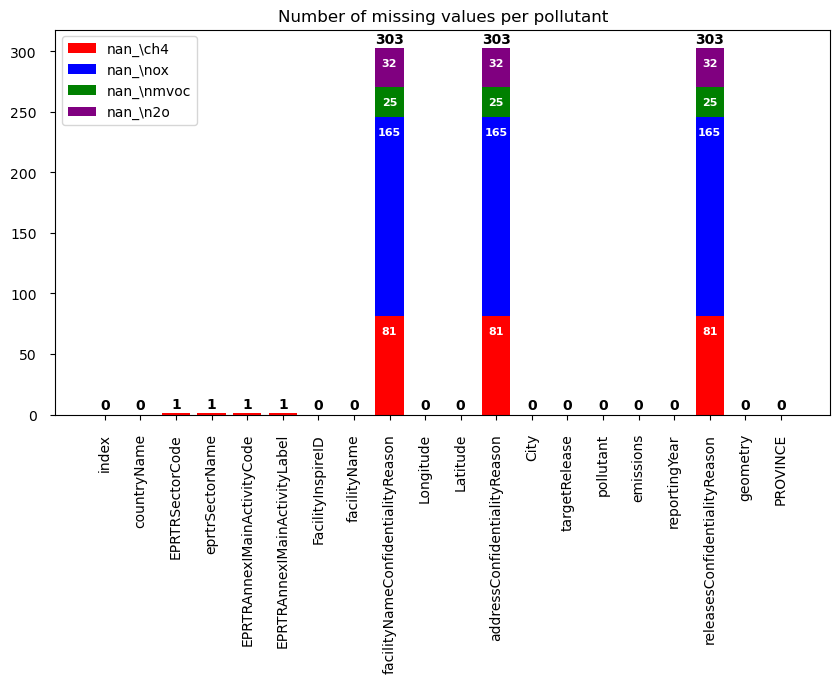

In [39]:
fig, ax = plt.subplots(figsize = (10,5))

colors = ['red', 'blue','green', 'purple']
bottom = np.zeros(len(nan_pollutants))

for i, col in enumerate(nan_pollutants.columns):
  ax.bar(
      nan_pollutants.index, nan_pollutants[col], bottom=bottom, label=col, color=colors[i])
  bottom += np.array(nan_pollutants[col])

totals = nan_pollutants.sum(axis=1)
y_offset = 4
for i, total in enumerate(totals):
  ax.text(totals.index[i], total + y_offset, round(total), ha='center',
          weight='bold')

y_offset = -15

for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(bar.get_height()),
      ha='center',
      color='w',
      weight='bold',
      size=8
  )

plt.xticks(rotation=90)
ax.tick_params(axis='both', which='major', pad=10)
ax.set_title('Number of missing values per pollutant')
ax.legend()

**In the graphic above, we see that the majority of the information with missing values are not relevant for this study. However, the subset *"nan_CH4"* has one important column (*eprtrsSectorName*) without information. As it is only 1 missing value out of 81 normal values, we decided just to remove this row.**

In [40]:
ind_ch4[ind_ch4["eprtrSectorName"].isna()]

,index,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,facilityNameConfidentialityReason,Longitude,Latitude,addressConfidentialityReason,City,targetRelease,pollutant,emissions,reportingYear,releasesConfidentialityReason,geometry,PROVINCE
33,1086,Poland,NaN,NaN,NaN,NaN,PL.MŚ/000001594.FACILITY,Przedsiębiorstwo Użyteczności Publicznej EKOSK...,NaN,18.647778,52.900002,NaN,Służewo,AIR,Methane (CH4),160000.0,2019,NaN,POINT (18.64778 52.90000),Kujawsko-pomorskie


In [41]:
idx_to_be_deleted = ind_ch4[ind_ch4["eprtrSectorName"].isna()].index

In [42]:
ind_ch4_clean = ind_ch4.drop(idx_to_be_deleted).reset_index(drop=True)

## Sum of emissions for each pollutant per province

**We are going to combine the data in a way to get the total pollutants' emissions per province. Below we made a function to receive a base dataframe which will be fed by another dataframe with the emissions per province and sum them up in the base dataframe:**

In [43]:
sum_per_province = provinces.copy()

In [44]:
def sum_emissions(df_base, df_additional, new_feature):
    df_base[new_feature]=0
    for i in range(len(df_base)):
        name = df_base["NAME"][i]
        df = df_additional[df_additional["PROVINCE"]==name]
        sum_emissions = sum(df["emissions"])
        df_base[new_feature][i]=sum_emissions
    return df_base

**Adding one by one the new features with the summed up emissions:**

In [45]:
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_ch4_clean, new_feature="EMISSIONS_CH4")
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_nox, new_feature="EMISSIONS_NOX")
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_nmvoc, new_feature="EMISSIONS_NMVOC")
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_n2o, new_feature="EMISSIONS_N2O")

In [46]:
sum_per_province.head(2)

,NAME,AREA,geometry,CENTER,EMISSIONS_CH4,EMISSIONS_NOX,EMISSIONS_NMVOC,EMISSIONS_N2O
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),1561000,4983000,0,0
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),72668000,2230000,0,78900


**Overview of the total emissions of one of the pollutants (NOx) per province:**

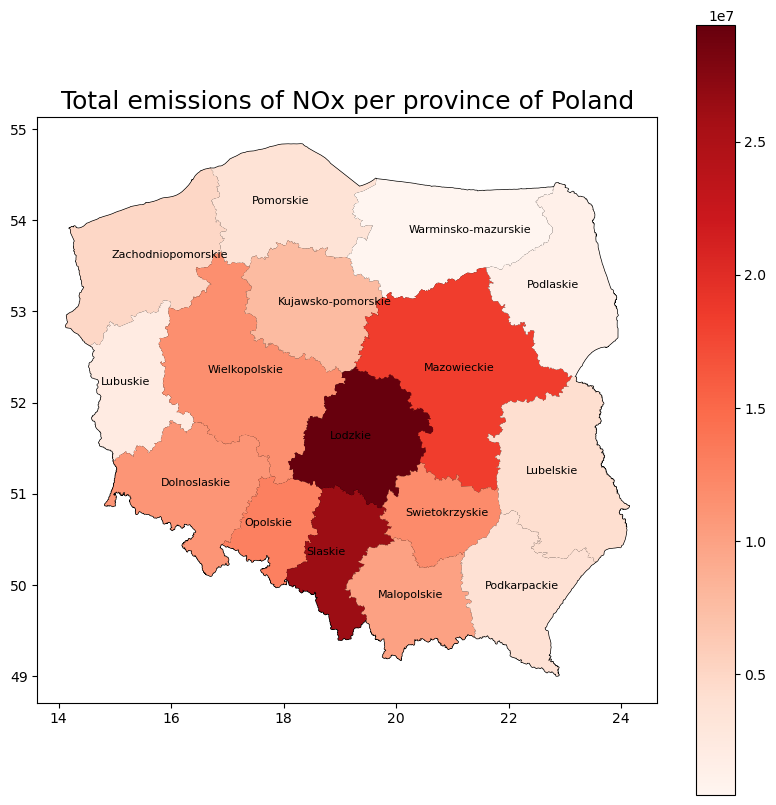

In [47]:
p = sum_per_province.plot(color="white", edgecolor="black", figsize = (10,10))

# Some hassle to add annotation to the map (found solution via Google)
sum_per_province["CENTER"] = sum_per_province["geometry"].centroid
sum_per_province_points = sum_per_province.copy()
sum_per_province_points.set_geometry(sum_per_province["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sum_per_province_points.geometry.x, 
                       sum_per_province_points.geometry.y, 
                       sum_per_province_points["NAME"]):
    texts.append(plt.text(x-0.6, y, label, fontsize = 8))
    
sum_per_province.plot(column='EMISSIONS_NOX', ax=p, legend=True, cmap='Reds')

#p.axis('off')
p.set_title('Total emissions of NOx per province of Poland', fontsize=18)
plt.show()

---

## Distribution of emissions from each sector per province

In [48]:
sector_province = provinces.copy()

In [49]:
sector_province

,NAME,AREA,geometry,CENTER
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506)
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617)
2,Dolnoslaskie,2.55916927233,"POLYGON ((16.91342 50.44976, 16.91210 50.44982...",POINT (16.41069 51.08950)
3,Wielkopolskie,3.93220020515,"POLYGON ((18.14065 52.50609, 18.14115 52.50605...",POINT (17.24310 52.33078)
4,Pomorskie,2.68945114136,"POLYGON ((18.82439 54.62561, 18.82619 54.62326...",POINT (18.03790 54.17734)
5,Opolskie,1.19620046778,"POLYGON ((17.74135 50.28711, 17.74138 50.28771...",POINT (17.89988 50.64711)
6,Kujawsko-pomorskie,2.40941372674,"POLYGON ((18.14065 52.50609, 18.14011 52.50601...",POINT (18.48822 53.07270)
7,Slaskie,1.55733578555,"MULTIPOLYGON (((19.83803 50.59001, 19.83754 50...",POINT (18.99410 50.33108)
8,Lodzkie,2.36362021645,"POLYGON ((20.42486 51.61167, 20.42489 51.61162...",POINT (19.41760 51.60487)
9,Malopolskie,1.8985108988,"POLYGON ((20.80878 49.35366, 20.80898 49.35375...",POINT (20.26934 49.85895)


**The names of the industrial sectors are too long. Let's make a dictionary with a shorter version for those names:**

In [50]:
code_sector = {'Animal and vegetable products from the food and beverage sector': "FOOD_BEVERAGE",
       'Chemical industry': "CHEMICAL", 
       'Energy sector': "ENERGY",
       'Intensive livestock production and aquaculture': "LIVESTOCK",
       'Mineral industry': "MINERAL", 
       'Other activities': "OTHER",
       'Paper and wood production and processing': "PAPER_WOOD",
       'Production and processing of metals': "METALS",
       'Waste and wastewater management': "WASTE"}

**And here a function to create a new columns with the new short-version names:**

In [51]:
def easier_name_for_sector(industry_dataset):
    
    for i,j in code_sector.items():
        idx = industry_dataset[industry_dataset["eprtrSectorName"]==i].index
        industry_dataset.loc[idx,"code_sector"]=j
    return industry_dataset

In [52]:
ind_ch4_clean2 = easier_name_for_sector(industry_dataset = ind_ch4_clean)
ind_nox2 = easier_name_for_sector(industry_dataset = ind_nox)
ind_nmvoc2 = easier_name_for_sector(industry_dataset = ind_nmvoc)
ind_n2o2 = easier_name_for_sector(industry_dataset = ind_n2o)
ind2 = easier_name_for_sector(industry_dataset = ind)

**This function is going to create new columns associating each pollutant (CH4, NOx, NMVOC, N2O) to each sector (CHEMICAL, ENERGY, FOOD_BEVERAGE, LIVESTOCK, METALS, MINERAL, PAPER_WOOD, WASTE, OTHER) per province.**

In [53]:
sectors = np.unique(ind["code_sector"].dropna())
province_names = np.unique(ind["PROVINCE"])

def sum_pollutant_sector_per_province(df_base, pollutant_df, pollutant_name):
    
    for i in range(len(province_names)):
        for j in range(len(sectors)):
            province_name = province_names[i]
            #print(province_name)
            sector_name = sectors[j]

            df = pollutant_df[(pollutant_df["code_sector"]==sector_name) & (pollutant_df["PROVINCE"]==province_name)]
            sum_emissions = sum(df["emissions"])

            #column_name = sectors[j]+"_" + pollutant_name
            column_name = sectors[j] + "_" + pollutant_name
            
            idx = df_base[df_base["NAME"]==province_name].index       
            df_base.loc[idx, column_name] = sum_emissions
            
    return df_base

In [54]:
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_ch4_clean, pollutant_name = "CH4")
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_nox, pollutant_name = "NOX")
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_nmvoc, pollutant_name = "NMVOC")
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_n2o, pollutant_name = "N2O")

**Adding traffic data to the base dataframe:**

In [55]:
sector_province["TRAFFIC_CH4"]=0
sector_province["TRAFFIC_N2O"]=0
sector_province["TRAFFIC_NMVOC"]=0
sector_province["TRAFFIC_NOX"]=0

def add_traffic(df_base, df_to_add, new_column_name):

    for i in range(len(df_base)):
    
        name = df_to_add["Voivodship"][i]
        quantity = df_to_add[df_to_add["Voivodship"]==name]["Total_kg"]
        idx = df_base[df_base["NAME"]==name].index
        df_base.loc[idx, new_column_name]=quantity[i]


In [56]:
add_traffic(df_base = sector_province, df_to_add = traffic_ch4, new_column_name = "TRAFFIC_CH4")
add_traffic(df_base = sector_province, df_to_add = traffic_n2o, new_column_name = "TRAFFIC_N2O")
add_traffic(df_base = sector_province, df_to_add = traffic_nmvoc, new_column_name = "TRAFFIC_NMVOC")
add_traffic(df_base = sector_province, df_to_add = traffic_nox, new_column_name = "TRAFFIC_NOX")

In [57]:
sector_province.head(2)

,NAME,AREA,geometry,CENTER,CHEMICAL_CH4,ENERGY_CH4,FOOD_BEVERAGE_CH4,LIVESTOCK_CH4,METALS_CH4,MINERAL_CH4,...,LIVESTOCK_N2O,METALS_N2O,MINERAL_N2O,OTHER_N2O,PAPER_WOOD_N2O,WASTE_N2O,TRAFFIC_CH4,TRAFFIC_N2O,TRAFFIC_NMVOC,TRAFFIC_NOX
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),0.0,561000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11638.689972,31269.646109,43952.368059,2.030799e+06
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),0.0,0.0,0.0,0.0,0.0,72520000.0,...,0.0,0.0,78900.0,0.0,0.0,0.0,7974.747629,26772.646467,31488.321870,1.410837e+06


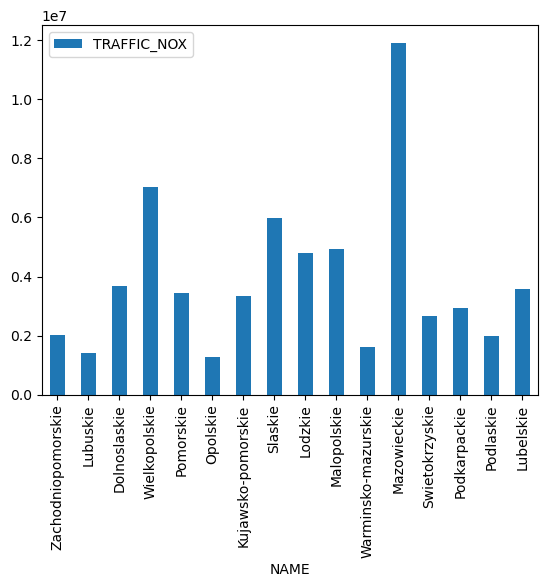

In [58]:
ax = sector_province.plot.bar(x='NAME', y='TRAFFIC_NOX', rot=90)

## Separating data per pollutant type:

In [59]:
sector_province_ch4_features = ['NAME', 'geometry', 'CENTER','CHEMICAL_CH4', 'ENERGY_CH4',
       'FOOD_BEVERAGE_CH4', 'LIVESTOCK_CH4', 'METALS_CH4', 'MINERAL_CH4',
       'OTHER_CH4', 'PAPER_WOOD_CH4', 'WASTE_CH4', 'TRAFFIC_CH4']

sector_province_nox_features = ['NAME', 'geometry', 'CENTER', 'CHEMICAL_NOX',
       'ENERGY_NOX', 'FOOD_BEVERAGE_NOX', 'LIVESTOCK_NOX', 'METALS_NOX',
       'MINERAL_NOX', 'OTHER_NOX', 'PAPER_WOOD_NOX', 'WASTE_NOX', 'TRAFFIC_NOX']

sector_province_nmvoc_features = ['NAME', 'geometry', 'CENTER', 'CHEMICAL_NMVOC', 'ENERGY_NMVOC', 'FOOD_BEVERAGE_NMVOC',
       'LIVESTOCK_NMVOC', 'METALS_NMVOC', 'MINERAL_NMVOC', 'OTHER_NMVOC',
       'PAPER_WOOD_NMVOC', 'WASTE_NMVOC', 'TRAFFIC_NMVOC']
 
sector_province_n2o_features = ['NAME', 'geometry', 'CENTER', 'CHEMICAL_N2O', 'ENERGY_N2O',
       'FOOD_BEVERAGE_N2O', 'LIVESTOCK_N2O', 'METALS_N2O', 'MINERAL_N2O',
       'OTHER_N2O', 'PAPER_WOOD_N2O', 'WASTE_N2O', 'TRAFFIC_N2O']
 
traffic_province_pollutants_features = ['NAME', 'geometry', 'CENTER', 'TRAFFIC_CH4', 'TRAFFIC_N2O', 'TRAFFIC_NMVOC', 'TRAFFIC_NOX']

sector_province_ch4 = sector_province[sector_province_ch4_features]
sector_province_nox = sector_province[sector_province_nox_features]
sector_province_nmvoc = sector_province[sector_province_nmvoc_features]
sector_province_n2o = sector_province[sector_province_n2o_features]
traffic_province_pollutants = sector_province[traffic_province_pollutants_features]

### Visualizations:

**In the graph below, we can see the enormous participation of the energy sector (orange color) in the total contribution of NOx emissions, especially in the provinces of Slaskie, Lodzkie, and Mazowieckie. In second place, emissions from motor vehicle traffic (urban buses, lorries, and road tractors) are present in all provinces, with the highest level in the province of Mazowieckie, which contains the city of Warsaw, the capital and largest city of Poland. In third place comes the mining industry, which, despite emitting little in comparison to the first two polluting agents, has a relatively extensive presence in the Polish territory. The rest have scattered, localized, and low contributions.** \

**One factor that stands out is the absence of NOx emissions from intensive livestock. A quick search of the data showed that in 2019, the fractions recorded for the entire livestock and aquaculture industry were 80% NH3, 10% CH4, 4% N2O, and 4% PM10. Therefore, the vast majority of nitrogen gas emissions are expelled in the form of ammonia.**

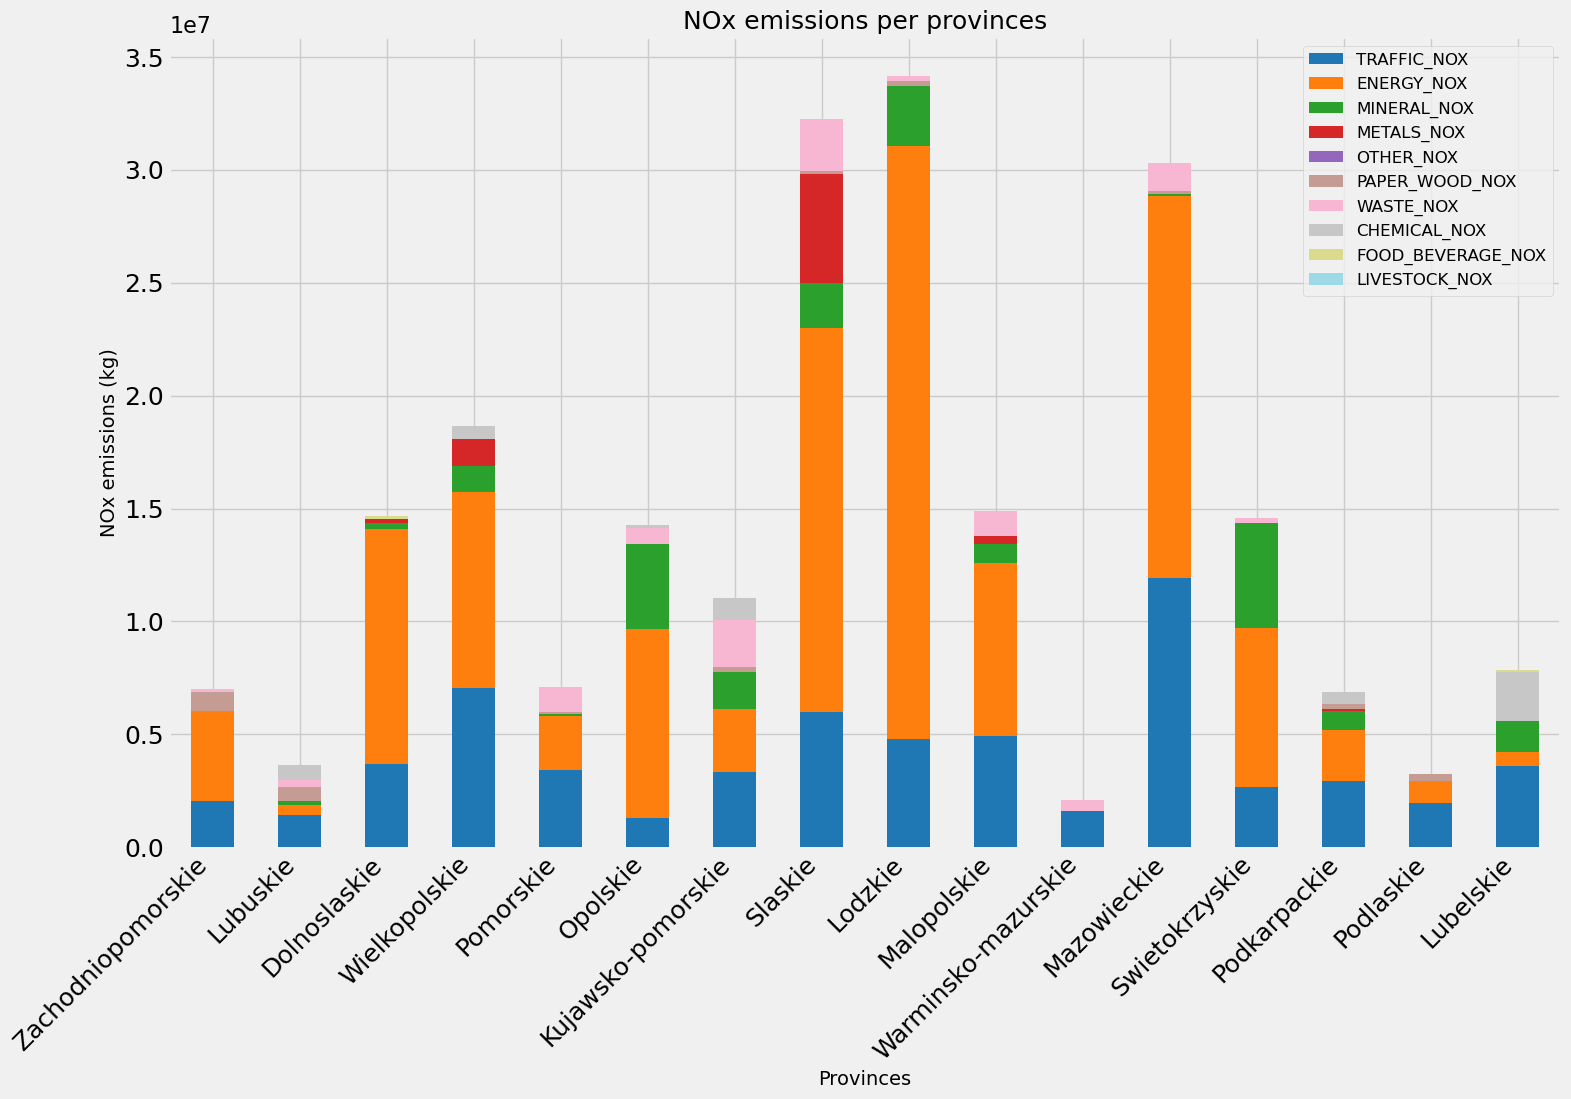

In [127]:
dftemp = sector_province_nox.copy()
dftemp.index = dftemp["NAME"]

colormap="tab20"

order = ['TRAFFIC_NOX', 'ENERGY_NOX', 'MINERAL_NOX', 'METALS_NOX','OTHER_NOX', 
       'PAPER_WOOD_NOX', 'WASTE_NOX', 'CHEMICAL_NOX', 'FOOD_BEVERAGE_NOX', 'LIVESTOCK_NOX']

dftemp[order].plot(kind='bar', stacked=True, figsize = (16,10), zorder=3, fontsize=18, cmap=colormap)
plt.title("NOx emissions per provinces", fontsize=18)
plt.xlabel("Provinces", fontsize=14)
plt.ylabel("NOx emissions (kg)", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(zorder=0)

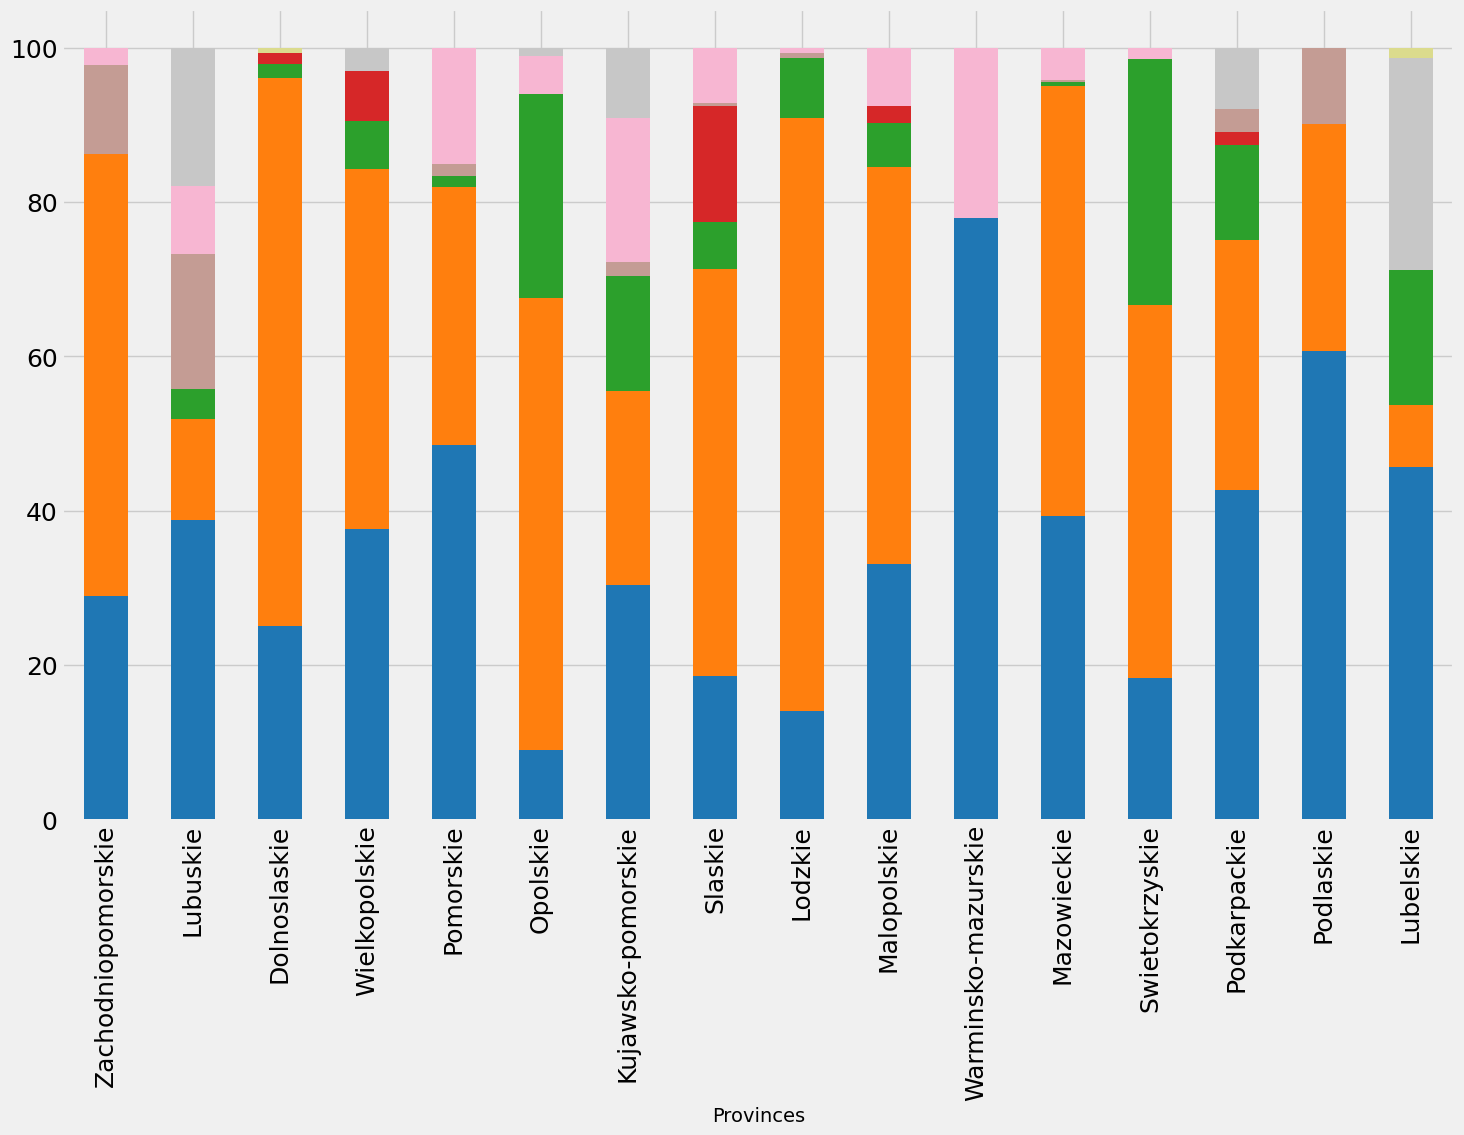

In [126]:
dftemp = sector_province_nox.copy()
dftemp.index = dftemp["NAME"]

stacked_data = dftemp[order].apply(lambda x: x*100/sum(x), axis=1)
ax = stacked_data.plot(kind="bar", stacked=True, figsize = (16,10), fontsize=18, legend=False, zorder=3, cmap=colormap)
plt.xlabel("Provinces", fontsize=14)
plt.grid(zorder=0)

### Choropleth maps:

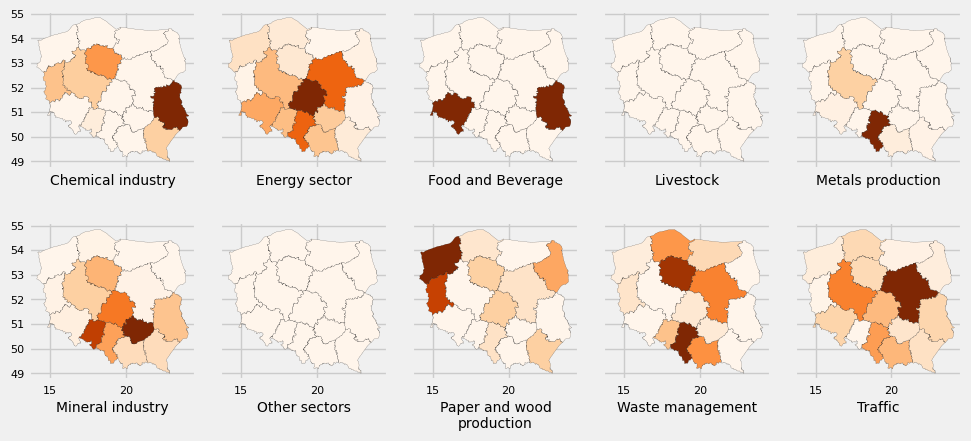

In [136]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(10,5), sharex=True, sharey=True)

lw = 0.1

sector_province_nox.plot(ax=ax1, column='CHEMICAL_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax2, column='ENERGY_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax3, column='FOOD_BEVERAGE_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax4, column='LIVESTOCK_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax5, column='METALS_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax6, column='MINERAL_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax7, column='OTHER_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax8, column='PAPER_WOOD_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax9, column='WASTE_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)
sector_province_nox.plot(ax=ax10, column='TRAFFIC_NOX', cmap='Oranges', edgecolor="black", linewidth=lw)

ax1.set_xlabel('Chemical industry', fontsize=10)
ax2.set_xlabel('Energy sector', fontsize=10)
ax3.set_xlabel('Food and Beverage', fontsize=10)
ax4.set_xlabel('Livestock', fontsize=10)
ax5.set_xlabel('Metals production', fontsize=10)
ax6.set_xlabel('Mineral industry', fontsize=10)
ax7.set_xlabel('Other sectors', fontsize=10)
ax8.set_xlabel('Paper and wood'  +'\n' + 'production', fontsize=10)
ax9.set_xlabel('Waste management', fontsize=10)
ax10.set_xlabel('Traffic', fontsize=10)

ax1.tick_params(axis='y', labelsize=8)
ax6.tick_params(axis='y', labelsize=8)

ax6.tick_params(axis='x', labelsize=8)
ax7.tick_params(axis='x', labelsize=8)
ax8.tick_params(axis='x', labelsize=8)
ax9.tick_params(axis='x', labelsize=8)
ax10.tick_params(axis='x', labelsize=8)

fig.tight_layout()

---

In [63]:
traffic_province_pollutants["LOG_TRAFFIC_NOX"] = np.log(traffic_province_pollutants["TRAFFIC_NOX"])

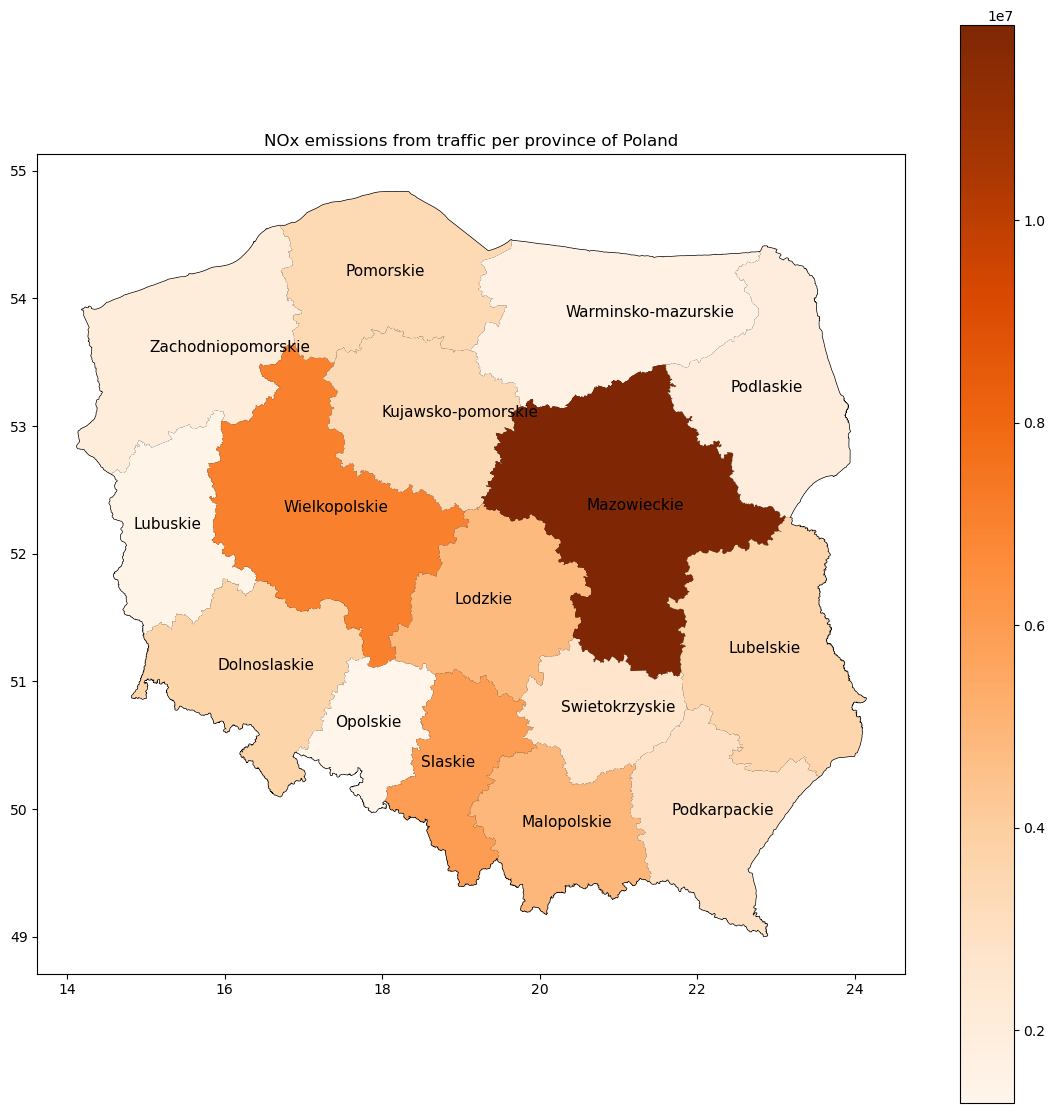

In [64]:
p = traffic_province_pollutants.plot(color="white", edgecolor="black", figsize = (14,14))

traffic_province_pollutants["CENTER"] = traffic_province_pollutants["geometry"].centroid
sector_province_points = traffic_province_pollutants.copy()
sector_province_points.set_geometry(traffic_province_pollutants["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sector_province_points.geometry.x, sector_province_points.geometry.y, sector_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
traffic_province_pollutants.plot(column='TRAFFIC_NOX', ax=p, figsize = (20,16), legend=True, cmap='Oranges')

p.set_title('NOx emissions from traffic per province of Poland')

plt.show()

### Types of pollutants from traffic:

In [65]:
A = traffic_province_pollutants[['TRAFFIC_CH4', 'TRAFFIC_N2O', 'TRAFFIC_NMVOC', 'TRAFFIC_NOX']]
A.index = list(traffic_province_pollutants['NAME'])

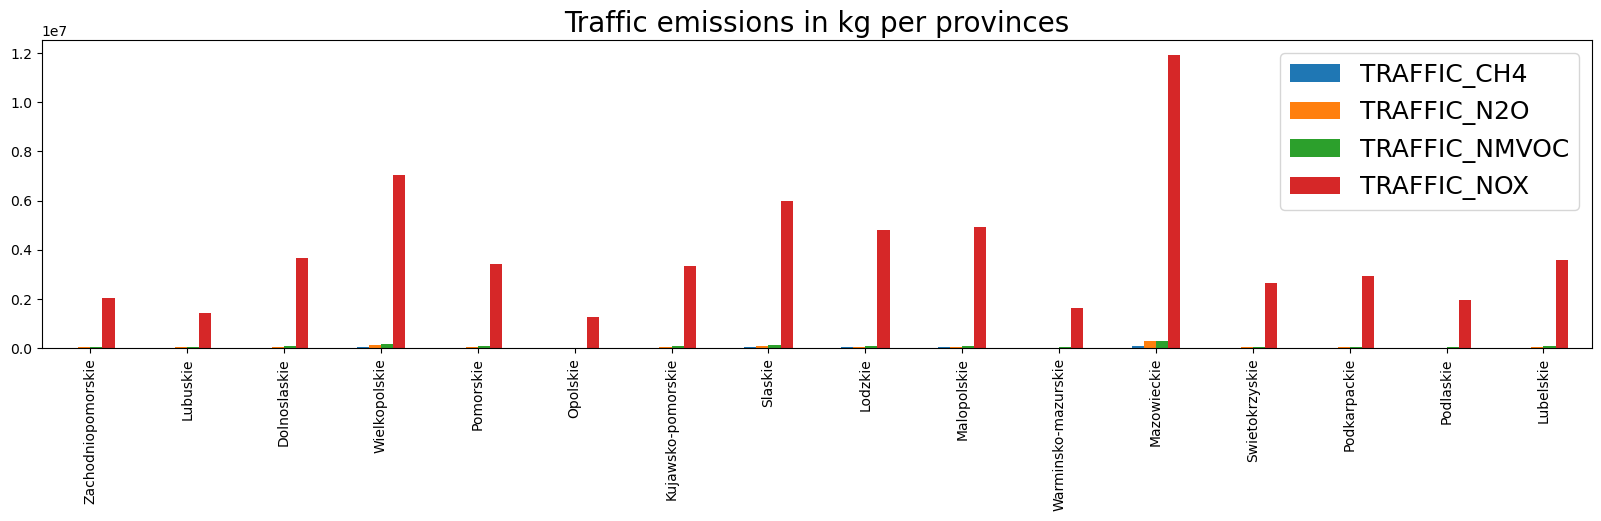

In [66]:
ax = A.plot.bar(figsize = (20,4), rot=90)
ax.set_title('Traffic emissions in kg per provinces', fontsize=18)
ax.legend(fontsize=18)
ax.title.set_size(20)

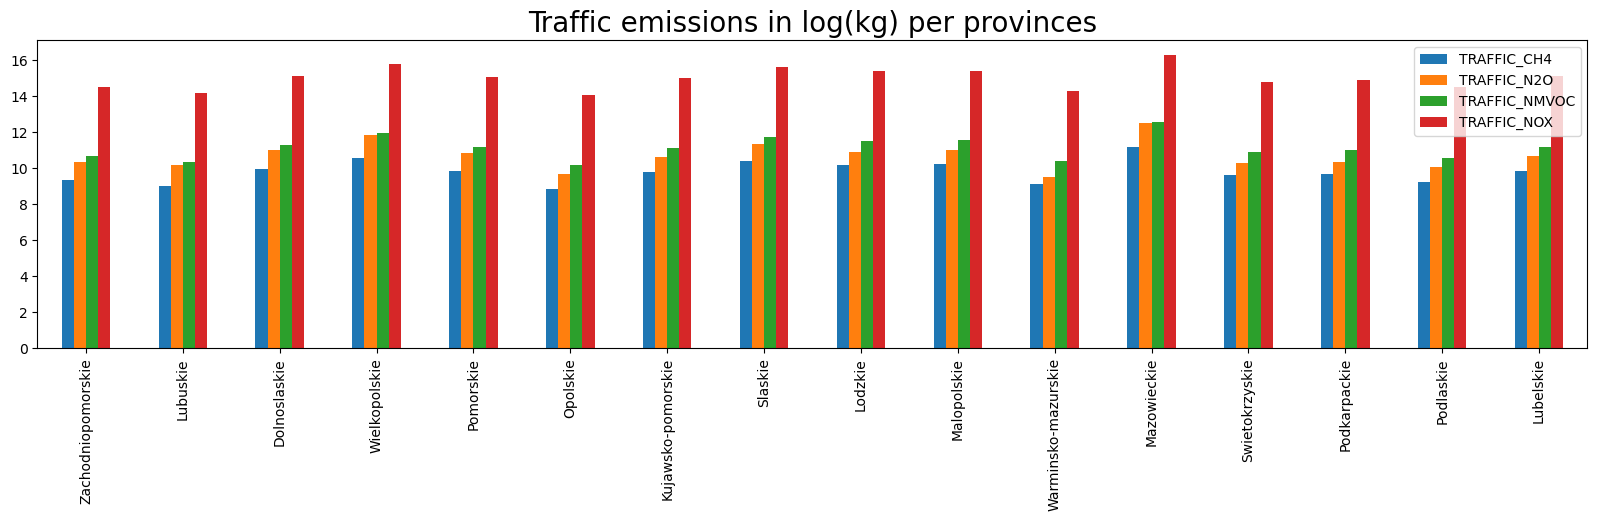

In [67]:
ax = np.log(A).plot.bar(figsize = (20,4), rot=90)
ax.set_title('Traffic emissions in log(kg) per provinces')
ax.title.set_size(20)

In [68]:
Aa = A.reset_index()
Aa.columns = ['NAME', 'TRAFFIC_CH4', 'TRAFFIC_N2O', 'TRAFFIC_NMVOC', 'TRAFFIC_NOX']
Aa

,NAME,TRAFFIC_CH4,TRAFFIC_N2O,TRAFFIC_NMVOC,TRAFFIC_NOX
0,Zachodniopomorskie,11638.689972,31269.646109,43952.368059,2.030799e+06
1,Lubuskie,7974.747629,26772.646467,31488.321870,1.410837e+06
2,Dolnoslaskie,20884.222273,60240.826750,80021.972450,3.662470e+06
3,Wielkopolskie,39512.142727,135023.286430,156640.965800,7.030304e+06
4,Pomorskie,18335.090912,51366.090120,70954.811300,3.435681e+06
5,Opolskie,6898.084441,16057.222969,25930.371229,1.281375e+06
6,Kujawsko-pomorskie,17973.168800,41018.953786,67587.004360,3.345258e+06
7,Slaskie,32896.085506,83971.278240,125089.462820,5.974575e+06
8,Lodzkie,26851.228902,55061.341870,98497.891630,4.786257e+06
9,Malopolskie,27890.451085,61891.791920,102698.474540,4.924869e+06


---

# Air pollution dataset (target)

**This data was acquired by air quality measurement stations and is provided in two different csv files: *stations (Kod stacji)* and *pollutant emissions per hour*. The first file has the name of these stations and their coordinates; the second file has the name of these stations and their emissions per hour. The first step is cleaning the "NaN" or "-999" values and data without coordinates. The second step is combine both files.**

In [69]:
stations = pd.read_excel(os.path.join(data_path, "Metadane oraz kody stacji i stanowisk pomiarowych.xlsx"))

In [70]:
def dfnan(df, name_df):
    cols = df.columns
    list_nan = []
    list_999 = []
    list_0 = []

    for i in range(len(cols)):
        counts1 = len(df[pd.isnull(df.iloc[:,i])])
        counts2 = len(df[df.iloc[:,i]==-999])
        counts3 = len(df[df.iloc[:,i]==0])
        list_nan.append(counts1)
        list_999.append(counts2)
        list_0.append(counts3)
        
    df = pd.DataFrame([list_nan], columns=cols).T
    df[1]  = list_999
    df[2]  = list_0
    df.columns = ["nan","-999","0"]  
    return df

dfnan(df = stations, name_df = "stations")

,nan,-999,0
Nr,0,0,0
Kod stacji,0,0,0
Kod międzynarodowy,353,0,0
Nazwa stacji,0,0,0
Stary Kod stacji \n(o ile inny od aktualnego),814,0,0
Data uruchomienia,0,0,0
Data zamknięcia,267,0,0
Typ stacji,0,0,0
Typ obszaru,0,0,0
Rodzaj stacji,0,0,0


**The coordinates and station names are the only important fields in the table above. Therefore, we must eliminate all instances of "-999" in these fields:**

In [71]:
stations = stations[stations["WGS84 φ N"]!=-999].reset_index(drop=True)

In [72]:
stations = stations[["Kod stacji","WGS84 φ N","WGS84 λ E"]]
stations.columns = ["Kod stacji","WGS84 N","WGS84 E"]

def preprocessing_air_pollution(pollutant_year):

    pollutant_year.columns = pollutant_year.iloc[0,:]
    pollutant_year = pollutant_year.iloc[5:,1:].reset_index(drop=True)
    pollutant_year = pollutant_year.astype(float)
    pollutant_year_mean = pd.DataFrame(pollutant_year.median(), columns=["MEAN_NOX"])
    pollutant_year_mean["Y"], pollutant_year_mean["X"] = 0, 0

    for i in range(len(stations)):

        name_station = stations["Kod stacji"][i] 
        pollutant_year_mean["Y"][name_station] = stations["WGS84 N"][i]
        pollutant_year_mean["X"][name_station] = stations["WGS84 E"][i]   
    
    pollutant_year_mean = pollutant_year_mean[pollutant_year_mean["X"]!=0]
    return pollutant_year_mean

In [73]:
NOX_2019 = pd.read_excel(os.path.join(data_path, "Wyniki pomiarów z 2019 roku", "2019_NOx_1g.xlsx"))
NOX_2019 = preprocessing_air_pollution(pollutant_year = NOX_2019)

---

# Interpolation (Ordinary Kriging)

**The information from the stations are available in point locations. We want to have a representative value for the whole province where these stations are within. The idea is generate a interpolation of these values through ordinary kriging, and the extract the mean values of the interpolated values per province.**

**First, let's have a look at the NOx values of those stations:**

In [74]:
NOX_2019 = gpd.GeoDataFrame(
    NOX_2019, geometry=gpd.points_from_xy(NOX_2019.X, NOX_2019.Y), crs="EPSG:4326")

NOX_2019["LOG_MEAN_NOX"] = np.log(NOX_2019["MEAN_NOX"])

<Axes: xlabel='0'>

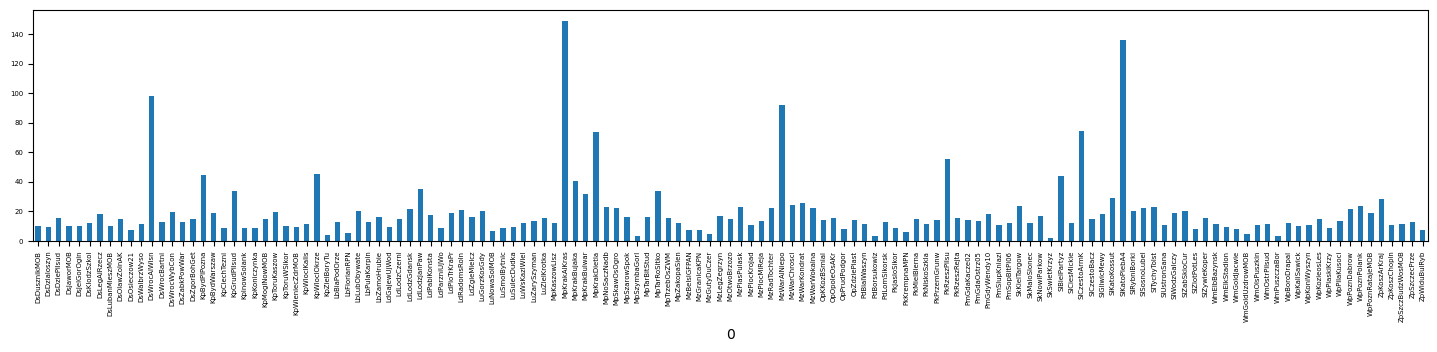

In [75]:
NOX_2019["MEAN_NOX"].plot.bar(figsize = (18,3), fontsize=5)

**There are some spikes in the plot bar above, these abrupt changes make the spatial correlation worse for the variogram (a necessary method to generate kriging maps). Then, we can try check the log of those values to make it less extreme:**

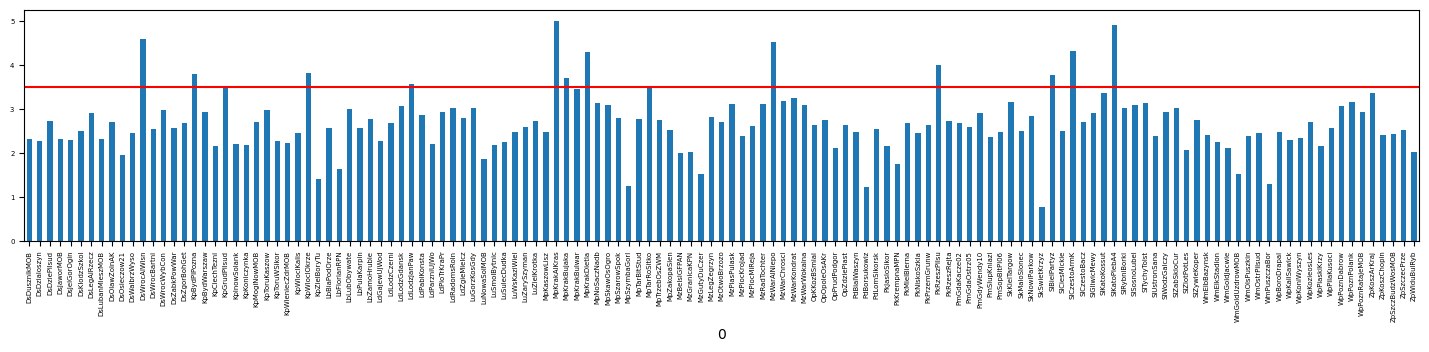

In [76]:
NOX_2019["LOG_MEAN_NOX"].plot.bar(figsize = (18,3), fontsize=5)
x1, y1 = [-10, 150], [3.5, 3.5]
plt.plot(x1, y1, marker = 'o', color='red')
plt.show()

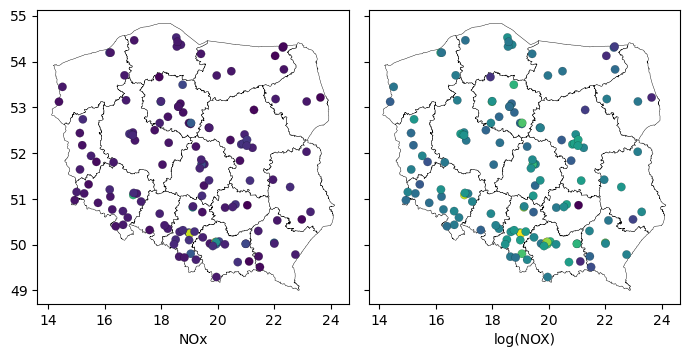

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7), sharex=True, sharey=True)

lw = 0.1

NOX_2019.plot(ax=ax1, column='MEAN_NOX', edgecolor="black", linewidth=lw)
NOX_2019.plot(ax=ax2, column='LOG_MEAN_NOX', edgecolor="black", linewidth=lw)

provinces.plot(ax=ax1, zorder=0, color="white", edgecolor="black", linewidth=0.3)
provinces.plot(ax=ax2, zorder=0, color="white", edgecolor="black", linewidth=0.3)

ax1.set_xlabel('NOx', fontsize=10)
ax2.set_xlabel('log(NOX)', fontsize=10)

#ax1.tick_params(axis='y', labelsize=8)
        
fig.tight_layout()

**Even though it helped a lot with the extreme values, the variogram was still indicating too much variance to show any significant spatial correlation. Then, we tried to cut off some spikes (values > 3.5) in the log(NOx) plot bar (red line).**

In [78]:
NOX_2019_cutoff = NOX_2019.reset_index(drop=True)
NOX_2019_cutoff = NOX_2019_cutoff[NOX_2019_cutoff["LOG_MEAN_NOX"]<3.5].reset_index(drop=True)

x = NOX_2019_cutoff["X"]
y = NOX_2019_cutoff["Y"]
z = NOX_2019_cutoff["LOG_MEAN_NOX"]

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.13572985183918737
Full Sill: 0.315368714746441
Range: 8.738375001741064
Nugget: 0.17963886290725362 



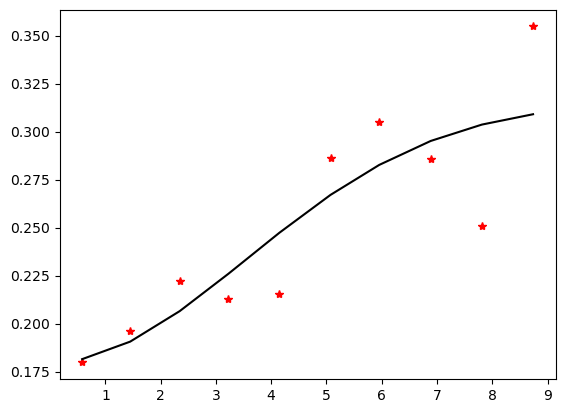

Calculating statistics on variogram model fit...


In [79]:
OK = OrdinaryKriging(
    x, 
    y, 
    z, 
    variogram_model='gaussian',
    verbose=True,
    enable_plotting=True,
    nlags=10,
)

**After making the specified changes, the variogram could be generated. But we can still see a large variability in short distances (nugget = 0.18). It makes sense though because we are using downscaled spatially (points to province) and temporally (hours to year) the information. It is indeed a lot of simplification, but as the purpose of this study is just about having an insight though mean values, we are just concerned with accuracy, and not with variability and precision.**

In [80]:
OK.variogram_model_parameters

array([0.13572985, 8.738375  , 0.17963886])

In [81]:
provinces.total_bounds

array([14.12288486, 49.00204323, 24.14578308, 54.83641667])

In [82]:
extent_y = provinces.total_bounds[1], provinces.total_bounds[3]
extent_x = provinces.total_bounds[0], provinces.total_bounds[2]

In [83]:
gridx = np.arange(extent_x[0], extent_x[1], 0.01, dtype='float64')
gridy = np.arange(extent_y[0], extent_y[1], 0.01, dtype='float64')
zstar, ss = OK.execute("grid", gridx, gridy)

Executing Ordinary Kriging...



In [84]:
print(zstar.shape)
print(ss.shape)

(584, 1003)
(584, 1003)


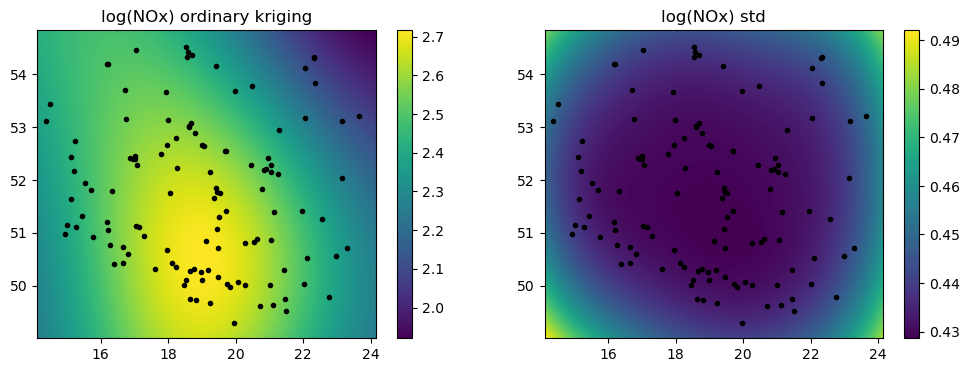

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
z = -1
for ax, interp in zip(axs, ['log(NOx) ordinary kriging', 'log(NOx) std']): 
    var = [zstar, np.sqrt(ss)]
    z = z + 1
    cax = ax.imshow(var[z], extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]), origin='lower', aspect='auto')
    ax.scatter(x, y, c='k', marker='.')
    ax.set_title(interp)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cax)#, cax=cbar_ax)
plt.show()

**On the images above, we have on the left the kriging map and on the right the standard deviation. Note that the interpolation was performed by extend, we still have to apply a spatial filter (Poland and provinces' boundaries) to eliminate extrapolated values from out area of interest.**

**Note: someway the raster was generated flipped vertically. The previous function "plt.imshow" used the option "origin='lower'" to plot correctly. However, the image remains flipped. The function "np.flip" below can correct this:**

In [86]:
zstar_flip = np.flip(zstar, axis=0)

In [87]:
data = zstar_flip.copy()

**We have a numpy array called "zstar" with the interpolation, but we want to transform it in a raster before applying a mask:**

In [88]:
def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
# Define the data extent (min. lon, min. lat, max. lon, max. lat)
extent = [14.122884859840275, 49.0020432310084, 24.145783075311037, 54.83641666701998] # South America
 
# Export the test array to GeoTIFF ================================================
 
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
 
# Get dimensions
nlines = data.shape[0]
ncols = data.shape[1]
nbands = len(data.shape)
#data_type = gdal.GDT_Int16 # gdal.GDT_Float32
data_type = gdal.GDT_Float32

# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('grid_data', ncols, nlines, 1, data_type)#, options)

# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(data)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))
 
# Save the file
file_name = 'log_nox_pollution.tif'
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(os.path.join(pp_data_path, file_name), grid_data, 0)  

# Close the file
driver = None
grid_data = None

# Delete the temp grid
import os                
os.remove('grid_data')


Generated GeoTIFF: log_nox_pollution.tif


**Now, load the figure saved:**

In [89]:
fp = r'log_nox_pollution.tif'
img1 = rasterio.open(os.path.join(pp_data_path, fp))

**... and load the Poland polygon to applying a mask in the raster:**

In [90]:
df = gpd.read_file(os.path.join(data_path, 'polska.shp'))
df  = df.to_crs({'init': 'epsg:4326'})
df.to_file(os.path.join(pp_data_path, "polska4326.shp"))

In [91]:
with fiona.open(os.path.join(pp_data_path, "polska4326.shp"), "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
     
with rasterio.open(os.path.join(pp_data_path, "log_nox_pollution.tif")) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta    
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(os.path.join(pp_data_path, "log_nox_clip_poland.tif"), "w", **out_meta) as dest:
    dest.write(out_image)    

The mask was saved. Now, let's check the result:

In [92]:
fp = 'log_nox_clip_poland.tif'
img2 = rasterio.open(os.path.join(pp_data_path, fp))

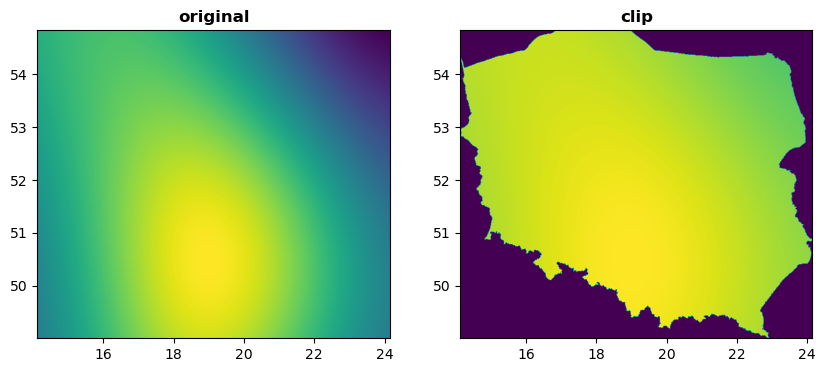

In [93]:
fig, (ax1, ax2) = pyplot.subplots(1,2, figsize=(10,4))

show(img1, ax=ax1, title='original', aspect='auto')

show(img2, ax=ax2, title='clip', aspect='auto')

pyplot.show()

Now it is time to extract the mean values of the raster for each of the provinces:

In [94]:
mean_pol_provinces = gpd.read_file(os.path.join(data_path, "wojewodztwa.shp"))
mean_pol_provinces  = mean_pol_provinces.to_crs({'init': 'epsg:4326'})
mean_pol_provinces = mean_pol_provinces[["JPT_NAZWA_", "SHAPE_AREA", "geometry"]]
mean_pol_provinces.columns = ["NAME", "AREA", "geometry"]
mean_pol_provinces = standard_names_for_provinces(dictionary = dic_provinces_to_standard, df_to_be_changed = mean_pol_provinces, name_column = "NAME")
mean_pol_provinces.to_file(os.path.join(pp_data_path, "wojewodztwa4326.shp"))

In [95]:
mean_pol_provinces.head(2)

,NAME,AREA,geometry
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417..."
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153..."


###  Extracting "NOx air pollution" per province:

**Creating a folder to storage the rasters:**

In [96]:
# Create the directory 
if not os.path.exists(path):
    os.mkdir(path)
    print("Directory '% s' created" % directory)
else:
    print("Directory '% s' already exists" % directory)

Directory 'original_datasets' already exists


In [97]:
# Path 
path_nox_province = os.path.join(pp_data_path, "nox_pol_per_province") 

# Create the directory 
if not os.path.exists(path_nox_province):
    os.mkdir(path_nox_province)
    print("Directory '% s' created" % directory)
else:
    print("Directory '% s' already exists" % directory)

Directory 'original_datasets' already exists


**Applying each province's polygon as a mask to the raster:**

In [98]:
for i in range(len(mean_pol_provinces)):

    with fiona.open(os.path.join(pp_data_path, "wojewodztwa4326.shp"), "r") as shapefile:
        shapefile = shapefile[i:i+1]
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(os.path.join(pp_data_path, "log_nox_clip_poland.tif")) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta    

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
   
    name_file = mean_pol_provinces["NAME"][i]

    with rasterio.open(os.path.join(path_nox_province, str(name_file+".tif")), "w", **out_meta) as dest:
        dest.write(out_image)    

In [99]:
df_base = sector_province_nox.copy()

**Calculating the mean values of the clipped rasters for each province and saving it in the dataframe:**

In [100]:
for i in range(len(df_base)):
    path_tifs = os.path.join(pp_data_path, "nox_pol_per_province")
    list_names = os.listdir(path_tifs)

    #ds = gdal.Open(path_tifs + list_names[i])
    ds = gdal.Open(os.path.join(path_tifs, list_names[i]))
    
    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
    mean_value = np.mean(myarray[myarray>0])
    name = list_names[i].split(".")[0]
    idx = df_base[df_base["NAME"]==name].index
    df_base.loc[idx, "LOG_POLLUTION_NOX"]=mean_value

In [101]:
df_base.head(2)

,NAME,geometry,CENTER,CHEMICAL_NOX,ENERGY_NOX,FOOD_BEVERAGE_NOX,LIVESTOCK_NOX,METALS_NOX,MINERAL_NOX,OTHER_NOX,PAPER_WOOD_NOX,WASTE_NOX,TRAFFIC_NOX,LOG_POLLUTION_NOX
0,Zachodniopomorskie,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),0.0,4021000.0,0.0,0.0,0.0,0.0,0.0,801000.0,161000.0,2.030799e+06,2.469517
1,Lubuskie,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),653000.0,478000.0,0.0,0.0,0.0,143000.0,0.0,636000.0,320000.0,1.410837e+06,2.450348


**Let's check the result:**

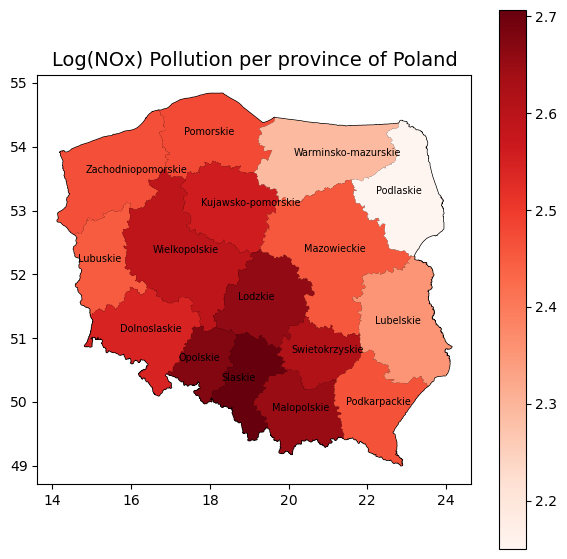

In [102]:
p = df_base.plot(color="white", edgecolor="black", figsize = (7,7))

# Some hassle to add annotation to the map (found solution via Google)
df_base["CENTER"] = df_base["geometry"].centroid
df_base_points = df_base.copy()
df_base_points.set_geometry(df_base["CENTER"], inplace = True)
texts = []

for x, y, label in zip(df_base_points.geometry.x, 
                       df_base_points.geometry.y, 
                       df_base_points["NAME"]):
    texts.append(plt.text(x-0.7, y, label, fontsize = 7))
    
df_base.plot(column='LOG_POLLUTION_NOX', ax=p, legend=True, cmap='Reds', aspect='auto')

#p.axis('off')
p.set_title('Log(NOx) Pollution per province of Poland', fontsize=14)
plt.show()

---

# Feature importance analysis

**According to Shin (2023),** *"Feature importance is a step in building a machine learning model that involves calculating the score for all input features in a model to establish the importance of each feature in the decision-making process. The higher the score for a feature, the larger effect it has on the model to predict a certain variable."* **In general, it is used to select the most meaniful features for the model training and then improve the performance of the model by reducing overfitting and training time. However, in this project, the features importance was applied to improve the *model interpretability*, which consists in gaining insights into the underlying relationships in the data and how the model is making predictions.**

**First, a new round of package importations:**

In [103]:
import pandas  as pd
import numpy   as np
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [104]:
df_base.head(2)

,NAME,geometry,CENTER,CHEMICAL_NOX,ENERGY_NOX,FOOD_BEVERAGE_NOX,LIVESTOCK_NOX,METALS_NOX,MINERAL_NOX,OTHER_NOX,PAPER_WOOD_NOX,WASTE_NOX,TRAFFIC_NOX,LOG_POLLUTION_NOX
0,Zachodniopomorskie,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),0.0,4021000.0,0.0,0.0,0.0,0.0,0.0,801000.0,161000.0,2.030799e+06,2.469517
1,Lubuskie,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),653000.0,478000.0,0.0,0.0,0.0,143000.0,0.0,636000.0,320000.0,1.410837e+06,2.450348


**Let's select the numerical features related to pollution:**

In [105]:
df_base.columns

Index(['NAME', 'geometry', 'CENTER', 'CHEMICAL_NOX', 'ENERGY_NOX',
       'FOOD_BEVERAGE_NOX', 'LIVESTOCK_NOX', 'METALS_NOX', 'MINERAL_NOX',
       'OTHER_NOX', 'PAPER_WOOD_NOX', 'WASTE_NOX', 'TRAFFIC_NOX',
       'LOG_POLLUTION_NOX'],
      dtype='object')

In [106]:
df_nox = df_base[['LOG_POLLUTION_NOX', 'CHEMICAL_NOX', 'ENERGY_NOX',
       'FOOD_BEVERAGE_NOX', 'LIVESTOCK_NOX', 'METALS_NOX', 'MINERAL_NOX',
       'OTHER_NOX', 'PAPER_WOOD_NOX', 'WASTE_NOX', 'TRAFFIC_NOX']]

In [107]:
df_nox

,LOG_POLLUTION_NOX,CHEMICAL_NOX,ENERGY_NOX,FOOD_BEVERAGE_NOX,LIVESTOCK_NOX,METALS_NOX,MINERAL_NOX,OTHER_NOX,PAPER_WOOD_NOX,WASTE_NOX,TRAFFIC_NOX
0,2.469517,0.0,4021000.0,0.0,0.0,0.0,0.0,0.0,801000.0,161000.0,2.030799e+06
1,2.450348,653000.0,478000.0,0.0,0.0,0.0,143000.0,0.0,636000.0,320000.0,1.410837e+06
2,2.545072,0.0,10422000.0,104000.0,0.0,208000.0,253000.0,0.0,0.0,0.0,3.662470e+06
3,2.591008,561000.0,8691000.0,0.0,0.0,1200000.0,1175000.0,0.0,0.0,0.0,7.030304e+06
4,2.475129,0.0,2368000.0,0.0,0.0,0.0,101000.0,0.0,102000.0,1070000.0,3.435681e+06
5,2.675931,159000.0,8367000.0,0.0,0.0,0.0,3765000.0,0.0,0.0,705000.0,1.281375e+06
6,2.560387,1000000.0,2783000.0,0.0,0.0,0.0,1652000.0,0.0,199000.0,2062000.0,3.345258e+06
7,2.706713,0.0,17025000.0,0.0,0.0,4844000.0,1967000.0,0.0,120000.0,2320000.0,5.974575e+06
8,2.658311,0.0,26270000.0,0.0,0.0,0.0,2658000.0,0.0,201000.0,252000.0,4.786257e+06
9,2.649688,0.0,7664000.0,0.0,0.0,333000.0,844000.0,0.0,0.0,1129000.0,4.924869e+06


**Before the training, it is recommended to standardize the data:**

In [108]:
df_nox = pd.DataFrame(StandardScaler().fit_transform(df_nox))

**Separating in training and test sets:**

In [109]:
X = df_nox.iloc[:,1:]
y = df_nox.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

**Running "*Grid Search*" to get optimal values of hyperparameters:**

In [110]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6, 7, 8, 9], # 7
              "n_estimators": [10, 20, 30, 40, 50, 60], # 22
              "learning_rate": [0.015, 0.02, 0.05, 0.1, 0.2, 0.3]} # 0.1

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 10}


**XGBoost**

In [111]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Model Evaluation:

In [112]:
scores = cross_val_score(regressor, X_train, y_train,cv=2)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: -0.01


In [113]:
kfold = KFold(n_splits=2, shuffle=True)
kf_cv_scores = cross_val_score(regressor, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: -0.05


**Cross-validation indicates that the performance of the model is acceptable, though it woud be better later to compare with other models. For now, this is good enough.**

In [114]:
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 1.83
RMSE: 1.35


**The most desirable value for the error metrics MSE and RMSE is zero, which would indicate that there is high accuracy and precision. However, those values indicate a relatively small bias and error std.**

### Feature importance graph:

In [115]:
feature_names = list(["Chemical_industry","Energy_sector", "Food and beverage",
                      "Livestock","Metal_production","Mineral_industry", "Other sectors","Paper_and_wood_production",
                      "Waste_management","Traffic"])

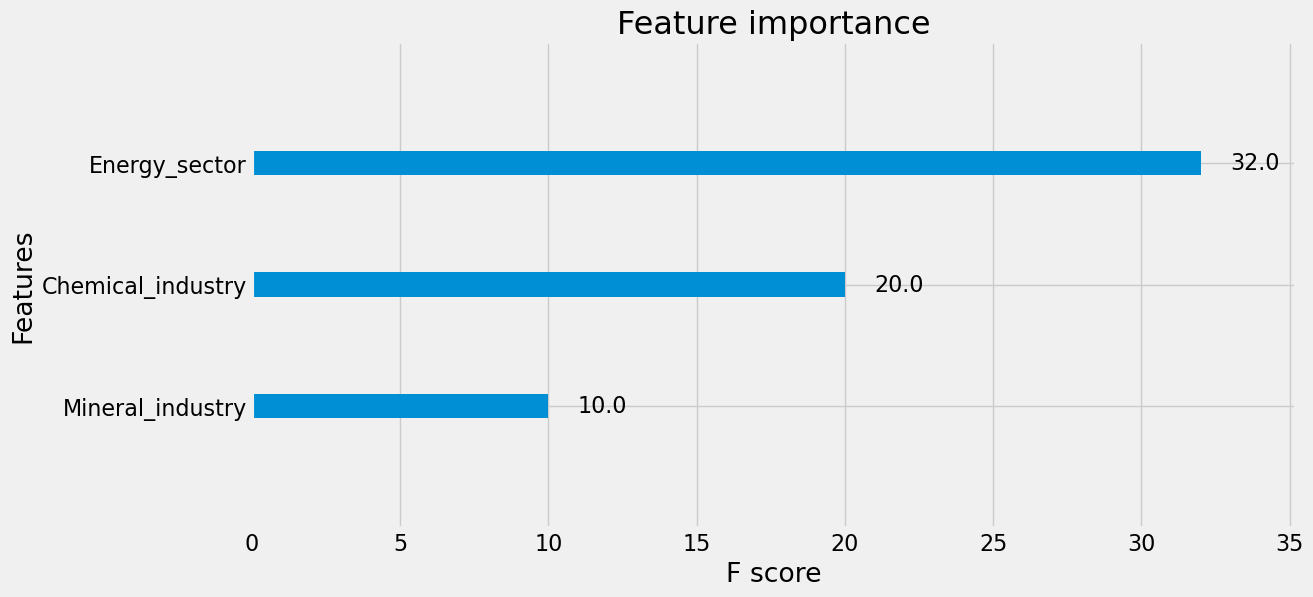

In [116]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

regressor.get_booster().feature_names = feature_names

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=9, ax=ax)
plt.show();

**The feature importance graph above shows that the NOx emissions from the energy sector is the feature that contributes most to the final prediction of NOx air pollution (score 32). In second place of importance comes the chemical industry, with 20 score. In third, mineral industry, with 10 score. The remaining features do not offer significant contribution to the final prediction.**

**It is important to note that not necessarily the factors that are responsible for large emissions of pollutants are the ones that contribute the most to the prediction. In this case, there was a coincidence with the energy sector, which is indeed a major polluter. However, the same cannot be said of the chemical industry, which seems to contribute precisely because it has an inverse correlation. Where there is a presence of enormous emissions, there is an absence of the chemical industry in the data; and the lower the total emissions of the provinces, the presence (although modest) of emissions from this industry is noted.**

---

# References

Shin, Terence. (2023, November 7). Understanding Feature Importance in Machine Learning. Built In. Available at: https://builtin.com/data-science/feature-importance. Accessed: January 25, 2024.

Azaria, N. (n.d.). Feature Importance: 7 Methods and a Quick Tutorial. The Aporia Academy. Available at: https://www.aporia.com/learn/feature-importance/feature-importance-7-methods-and-a-quick-tutorial/. Accessed: January 25, 2024.